In [16]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import fsolve
from gp_utils import GaussianProcessRegressor2dNoise

from eos_utils import gp_data

# define saturation up here
n0 = 0.164

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# solve for the length scale given some distance
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


In [409]:
# call training function to obtain desired data (for both data sets) (change now to test)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
}

cutoff = 20
chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, \
                                                          all_orders=False, matter='ANM')

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 1000)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(7,) (7,) (7,) (7, 7)
Cov shape: (15, 15)


In [410]:
from scipy.linalg import block_diag

# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][1::2],  # 1::2
    'mean': chiral_tr_data['mean'][1::2],
    'std': chiral_tr_data['std'][1::2],
    'cov': chiral_tr_data['cov'][1::2,1::2]
}

pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

training_data_2 = {
    'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
    'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
    'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
    'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
}

print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])


Density: 
 [ 0.09357262  0.17103506  0.2484975   0.32595993  3.29816361  5.48180301
  7.6654424   9.8490818  12.0327212  14.2163606  16.4       ]

Mean: 
 [0.04384642 0.10521407 0.19189235 0.26642541 1.12216728 1.10108283
 1.09103381 1.08485423 1.0805493  1.07731912 1.07477293]

Std dev: 
 [0.00439573 0.01597702 0.03677041 0.07065512 0.03371912 0.02196701
 0.01726267 0.01465635 0.0129697  0.01177373 0.01087309]


In [411]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

In [712]:
def matern_32(ls, val, euclidx):
    kernmat32 = (1.0 + np.sqrt(3)*euclidx/ls) * np.exp(-np.sqrt(3)*euclidx/ls)
    return val - kernmat32

def matern_52(ls, val, euclidx):
    kernmat_52 = (1.0 + np.sqrt(5)*euclidx/ls + 5.0*euclidx**2.0/(3*ls**2.0)) \
           * np.exp(-np.sqrt(5)*euclidx/ls)
    return val - kernmat_52

def rbf(ls, val, euclidx):
    rbfkern = np.exp(-euclidx**2.0/(2.0*ls**2.0))
    return val - rbfkern

def rat_quad(ls, val, euclidx):
    kernrq = (1.0 + euclidx**2.0/(2.0*2.0*ls**2.0))**(-2.0)
    return val - kernrq

# set euclidean distance
euclidx = 2.30

# value of the correlation expected (let's set an upper bound on the correlation) (1-2% correlated?)
val = 0.1625

In [713]:
root32 = fsolve(matern_32, [2.0], args=(val, euclidx))
rootrbf = fsolve(rbf, [2.0], args=(val, euclidx))
root52 = fsolve(matern_52, [2.0], args=(val, euclidx))
ratquadv = fsolve(rat_quad, [2.0], args=(val, euclidx))
print('Matern 3/2 scale obtained: ', root32[0])
print('Matern 5/2 length scale: ', root52[0])
print('Rational Quadratic length scale: ', ratquadv[0])
print('Length scale obtained: ', rootrbf[0])

Matern 3/2 scale obtained:  1.218899171299031
Matern 5/2 length scale:  1.2147471105416792
Rational Quadratic length scale:  0.9450724009894321
Length scale obtained:  1.2064967029557143


Table so far of values (1% = a; 2% = b):

Matern 3/2: a = 3.8; b = 4.7

Matern 5/2: a = 2.2; b = 2.6

Rational Quadratic: a = 1.1; b = 1.2

RBF: a = 1.0; b = 1.2

Table for 20n0: 

RBF: a = 0.89; b = 0.95

Matern 3/2: a = 1.8; b = 2.9

Matern 5/2: a = 1.1; b = 1.7

Rational Quadratic: a = 0.88; b = 0.95

In [714]:
# try this without any nugget or correlated data
maternk = Matern(length_scale = root32[0], length_scale_bounds = 'fixed', nu=1.5)
matern5k = Matern(length_scale = root52[0], length_scale_bounds='fixed', nu=2.5)
ratquad = RationalQuadratic(length_scale = ratquadv[0], length_scale_bounds='fixed', alpha=2.0)
rbfk = C(constant_value=1.1, constant_value_bounds='fixed') * RBF(length_scale = rootrbf[0], length_scale_bounds='fixed')

In [715]:
X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:431: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:431: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


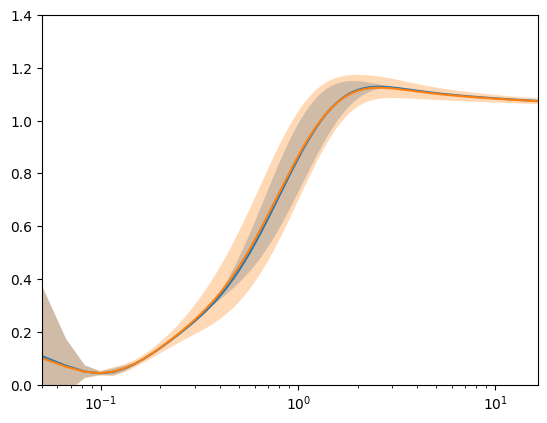

In [716]:
gp0 = GaussianProcessRegressor2dNoise(kernel=ratquad, alpha=0.0)

# gp1 = GaussianProcessRegressor2dNoise(kernel=ratquad, alpha=0.0)

# gp2 = GaussianProcessRegressor2dNoise(kernel=ratquad, alpha=0.0)

gp3 = GaussianProcessRegressor2dNoise(kernel=ratquad,
                                     alpha=training_data_2['cov'])

# try several cases
_, cov = gp1.predict(X_train_2, return_cov=True)
_, covpredict = gp2.predict(np.log(density_test).reshape(-1,1), return_cov=True)  # check this one 

gp0.fit(X_train_2, y_train_2, priors=False, cutoff=cutoff)
pred0, stdv0 = gp0.predict(np.log(density_test).reshape(-1,1), return_std=True)
_, cov0 = gp0.predict(np.log(density_test).reshape(-1,1), return_cov=True)

gp3.fit(X_train_2, y_train_2, priors=False, cutoff=cutoff)
pred3, stdv3 = gp3.predict(np.log(density_test).reshape(-1,1), return_std=True)
_, cov3 = gp3.predict(np.log(density_test).reshape(-1,1), return_cov=True)

index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

plt.plot(density_test, pred0)
plt.fill_between(density_test, pred0-stdv0, pred0+stdv0, alpha=0.3)
plt.plot(density_test, pred3)
plt.fill_between(density_test, pred3-stdv3, pred3+stdv3, alpha=0.3)
plt.xlim(min(density_test), max(density_test))
plt.ylim(0.0, 1.4)
plt.xscale('log')

In [717]:
# now look at the correlation coefficients (fitted one) and see what's happening (should be 0.05)
std_2n0 = stdv0[index_2n0]
std_40n0 = stdv0[index_40n0]

cov_2n0_40n0 = cov0[index_2n0, index_40n0]

# check cross correlation coefficient
print(cov_2n0_40n0/(std_2n0*std_40n0))

# check the result with the training correlations added
std3_2n0 = stdv3[index_2n0]
std3_40n0 = stdv3[index_40n0]

cov3_2n0_40n0 = cov3[index_2n0, index_40n0]
print(cov3_2n0_40n0/(std3_2n0*std3_40n0))

0.5912186039537075
0.019992749780673173


Ideas for what is happening: the training data covariance matrix is making the number smaller, so this might be a data-dependent kind of result, which would be unfortunate. 

In [718]:
# get out each matrix individually (try this for the gp3 cases too)
K_fet = gp0.kernel_(np.log(density_test).reshape(-1,1), X_train_2)  # full Kf,et and Kf,te (I think!)
K_fte = gp0.kernel_(X_train_2, np.log(density_test).reshape(-1,1))
K_inv = np.linalg.inv(gp0.kernel_(X_train_2, X_train_2) + training_data_2['cov'])
K_fee = gp0.kernel_(np.log(density_test).reshape(-1,1), np.log(density_test).reshape(-1,1))

# calculate the sigma ee by hand and verify with the cov output of predict
sigma_ee = K_fee - K_fet @ K_inv @ K_fte

# compare the two matrices (should be equal; here up to 10^-14
print(cov3 - sigma_ee)

# print the pieces of the matrix to see what is happening
print(K_fee[index_2n0, index_40n0])
rest = sigma_ee[index_2n0, index_40n0] - K_fee[index_2n0, index_40n0]
print(rest)

[[ 1.25466304e-12  8.96549501e-12  1.47878376e-11 ...  2.11214269e-09
   2.11034708e-09  2.10855857e-09]
 [ 6.73017198e-13  4.58932892e-12  7.58548779e-12 ...  1.08237186e-09
   1.08144502e-09  1.08052967e-09]
 [-9.93649607e-14  1.19015908e-12  2.18292051e-12 ...  3.19840505e-10
   3.19568491e-10  3.19297946e-10]
 ...
 [ 1.39770099e-13  2.05257225e-13  3.15540383e-13 ... -2.44729093e-09
  -2.44657083e-09 -2.44585030e-09]
 [-2.87652077e-13 -3.61538544e-13 -3.27081220e-13 ... -3.00939795e-09
  -3.00848579e-09 -3.00757130e-09]
 [ 1.48644118e-15 -1.86796853e-14  3.11133464e-14 ... -1.65682945e-09
  -1.65642211e-09 -1.65601388e-09]]
0.0077382586573784525
-0.0077093421860577474


In [719]:
# correlations in each term; Kfee is a correlation matrix!
kfrho = K_fee[index_2n0, index_40n0]/(np.sqrt(K_fee[index_2n0,index_2n0])
                                      *np.sqrt(K_fee[index_40n0,index_40n0]))
rest_matrix = K_fet @ K_inv @ K_fte

restrho = rest_matrix[index_2n0, index_40n0] / (np.sqrt(rest_matrix[index_2n0, index_2n0]) 
                                                * np.sqrt(rest_matrix[index_40n0, index_40n0]))

print('Value of rho: ', sigma_ee[index_2n0, index_40n0]/(np.sqrt(sigma_ee[index_2n0, index_2n0]) 
                                       * np.sqrt(sigma_ee[index_40n0, index_40n0])))

print('sigma_ee: ', sigma_ee[index_2n0, index_40n0])

Value of rho:  0.019992770681086406
sigma_ee:  2.8916471320705045e-05


In [720]:
# more checks...?
# try the single value of that matrix above to compare to each other
print(cov3[index_2n0, index_40n0], sigma_ee[index_2n0, index_40n0])

2.8916450949293022e-05 2.8916471320705045e-05


In [721]:
print(cov3[index_2n0,index_40n0]/(np.sqrt(cov3[index_2n0, index_2n0]) * 
                                       np.sqrt(cov3[index_40n0, index_40n0])))
print(sigma_ee[index_2n0, index_40n0]/(np.sqrt(sigma_ee[index_2n0, index_2n0]) * 
                                       np.sqrt(sigma_ee[index_40n0, index_40n0])))  # precise enough!

0.019992749780670147
0.019992770681086406


In [711]:
# print the final correlation number so we have an idea of what we need
print('Final correlation: ', sigma_ee[index_2n0, index_40n0]/(np.sqrt(sigma_ee[index_2n0, index_2n0]) * 
                                       np.sqrt(sigma_ee[index_40n0, index_40n0])))

Final correlation:  0.021368832797155138
